In [1]:
import requests
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
headers = {"accept": "application/json"}
query_params = {"markets": "KRW-BTC", "count":1}

url = f"https://api.upbit.com/v1/orderbook"

response = requests.get(url, headers=headers, params=query_params)

data = json.loads(response.text)

ask_price = np.array([d['ask_price'] for d in data[0]['orderbook_units']])
ask_size = np.array([d['ask_size'] for d in data[0]['orderbook_units']])
ask_price_weighted_mean = np.sum(ask_price*ask_size)/ask_size.sum()

bid_price = np.array([d['bid_price'] for d in data[0]['orderbook_units']])
bid_size = np.array([d['bid_size'] for d in data[0]['orderbook_units']])
bid_price_weighted_mean = np.sum(bid_price*bid_size)/bid_size.sum()

print(f"ask W mean: {ask_price_weighted_mean:.0f} KRW \nbid W mean: {bid_price_weighted_mean:.0f} KRW")



ask W mean: 90261058 KRW 
bid W mean: 90109051 KRW


In [9]:
def get_trade_price():
  url = "https://api.upbit.com/v1/ticker"
  headers = {"accept": "application/json"}
  query_params = {"markets": "KRW-BTC"}

  response = requests.get(url, headers=headers, params=query_params)
  res = json.loads(response.text)[0]
  return res['timestamp'], res['trade_price']

def get_orderbook_data():
  headers = {"accept": "application/json"}
  query_params = {"markets": "KRW-BTC", "count":1}

  url = f"https://api.upbit.com/v1/orderbook"
  response = requests.get(url, headers=headers, params=query_params)
  return json.loads(response.text)

In [76]:
def save_prices(count=10, timestep=1):
  weighted_prices = []
  total_weighted_prices = []
  trade_prices = []
  for i in range(count):
    
    trade_price=get_trade_price()
    data = get_orderbook_data()

    ask_price = np.array([d['ask_price'] for d in data[0]['orderbook_units']])
    ask_size = np.array([d['ask_size'] for d in data[0]['orderbook_units']])
    ask_price_weighted_mean = np.sum(ask_price*ask_size)/ask_size.sum()

    bid_price = np.array([d['bid_price'] for d in data[0]['orderbook_units']])
    bid_size = np.array([d['bid_size'] for d in data[0]['orderbook_units']])
    bid_price_weighted_mean = np.sum(bid_price*bid_size)/bid_size.sum()

    total_weighted_price = (np.sum(ask_price*ask_size)+np.sum(bid_price*bid_size)) / (ask_size.sum() + bid_size.sum())

    weighted_prices.append([data[0]['timestamp'], ask_price_weighted_mean, bid_price_weighted_mean])
    total_weighted_prices.append([data[0]['timestamp'], total_weighted_price])
    trade_prices.append(trade_price)
    time.sleep(timestep)
  return weighted_prices, trade_prices, total_weighted_prices

  

In [83]:
weighted_prices, trade_prices, total_weighted_prices = save_prices(count=1000, timestep=1)

In [84]:
weighted_prices = np.array(weighted_prices)
trade_prices = np.array(trade_prices)
total_weighted_prices = np.array(total_weighted_prices)

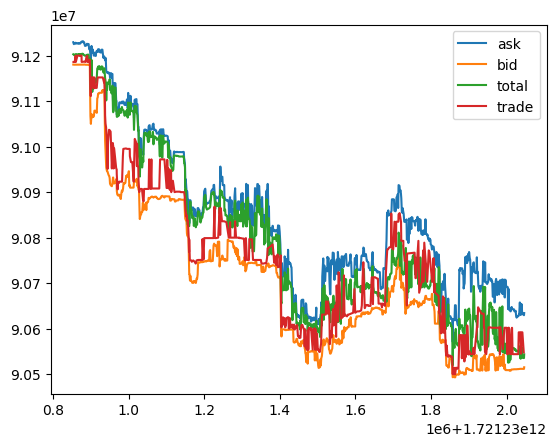

In [85]:
plt.plot(weighted_prices[:,0], weighted_prices[:,1], label="ask")
plt.plot(weighted_prices[:,0], weighted_prices[:,2], label="bid")
plt.plot(total_weighted_prices[:,0], total_weighted_prices[:,1], label="total")
plt.plot(trade_prices[:,0], trade_prices[:,1], label="trade")
plt.legend()
plt.show()

In [86]:
def smoothen(arr, k=2):
  # arr: [[t1, y1], [t2, y2], ...]
  ret = np.zeros_like(arr[k-1:,1])
  n = ret.shape[0]
  for i in range(k):
    ret += arr[i:n+i,1]
  ret /= k
  return np.vstack([arr[k-1:,0],ret]).T

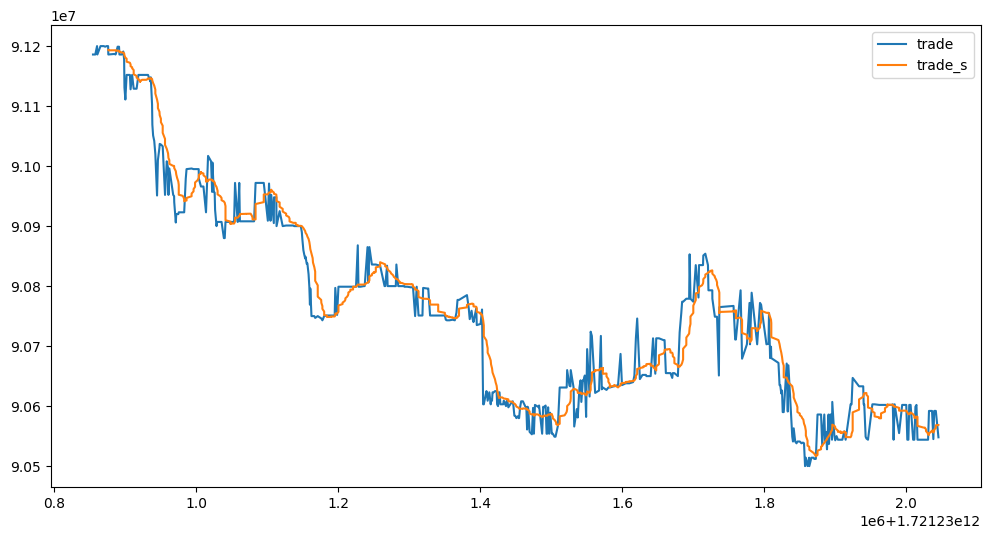

In [87]:
s = smoothen(trade_prices, k=20)
plt.figure(figsize=(12,6))
plt.plot(trade_prices[:,0], trade_prices[:,1], label="trade")
plt.plot(s[:,0], s[:,1], label="trade_s")

plt.legend()
plt.show()

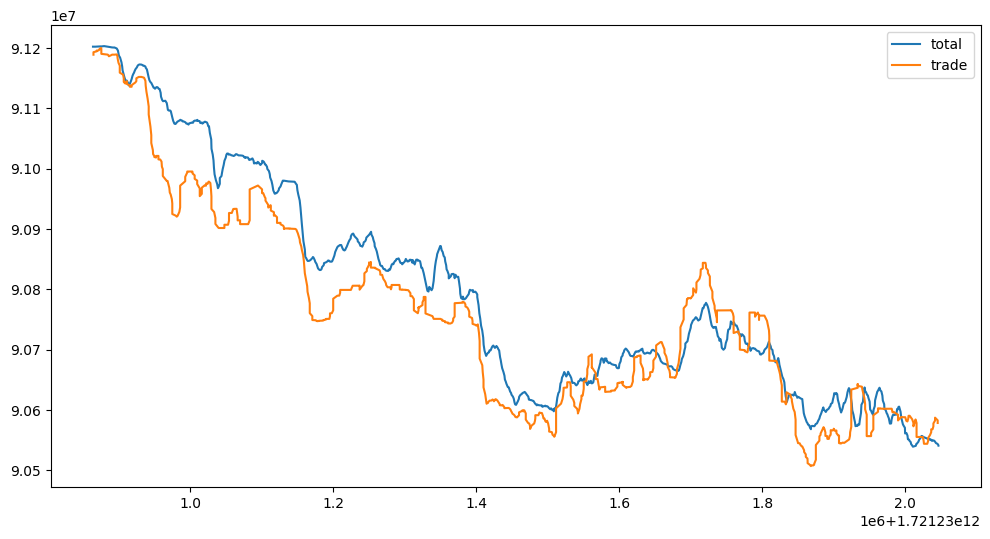

In [94]:
twps = smoothen(total_weighted_prices, k=10)
trps = smoothen(trade_prices, k=10)
plt.figure(figsize=(12,6))
plt.plot(twps[:,0], twps[:,1], label="total")
plt.plot(trps[:,0], trps[:,1], label="trade")
plt.legend()
plt.show()

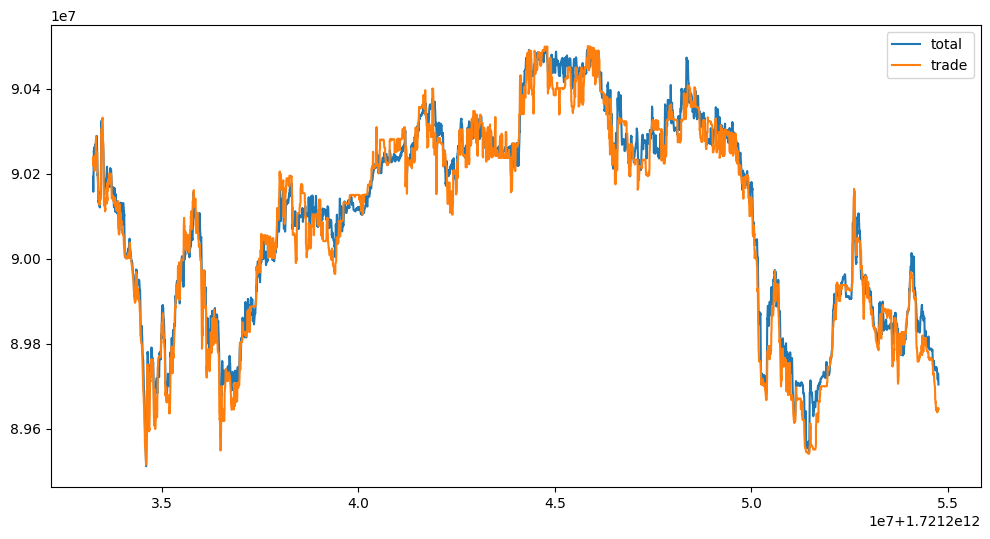

In [95]:
weighted_prices, trade_prices, total_weighted_prices = save_prices(count=3600*5, timestep=1)

weighted_prices = np.array(weighted_prices)
trade_prices = np.array(trade_prices)
total_weighted_prices = np.array(total_weighted_prices)

twps = smoothen(total_weighted_prices, k=10)
trps = smoothen(trade_prices, k=10)
plt.figure(figsize=(12,6))
plt.plot(twps[:,0], twps[:,1], label="total")
plt.plot(trps[:,0], trps[:,1], label="trade")
plt.legend()
plt.show()

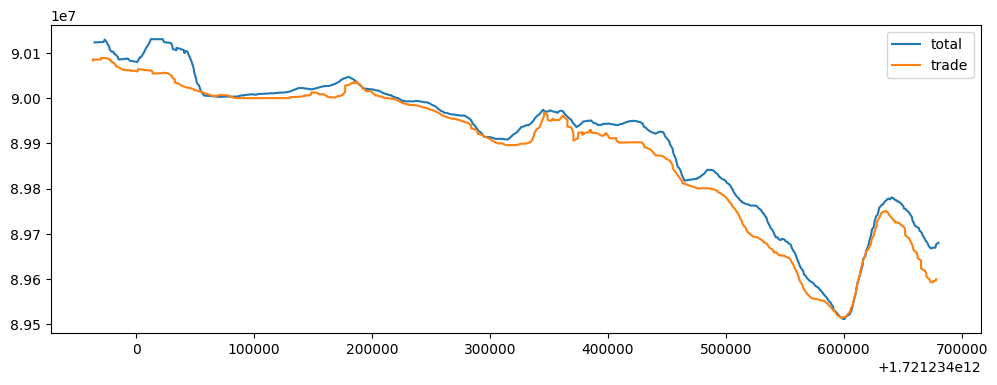

In [107]:
lim = [600, 1200]
plt.figure(figsize=(12,4))
plt.plot(twps[:,0][lim[0]:lim[1]], twps[:,1][lim[0]:lim[1]], label="total")
plt.plot(trps[:,0][lim[0]:lim[1]], trps[:,1][lim[0]:lim[1]], label="trade")
plt.legend()
plt.show()

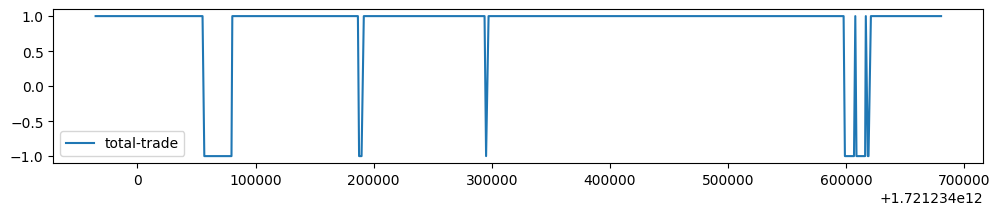

In [108]:
plt.figure(figsize=(12,2))
plt.plot(twps[:,0][lim[0]:lim[1]], np.clip(twps[:,1][lim[0]:lim[1]]-trps[:,1][lim[0]:lim[1]], -1, 1), label="total-trade")
plt.legend()
plt.show()

Weighted mean 방법은 사실 제일 중요한 정보를 반영하지 못하고 있음

bid에 몰려있다는건 매수자가 많다는 것이고, 그렇다면 가격 상승할 유인이 높은건데
wighted mean을 하면 bid쪽으로 평균이 형성되고, 낮은 total mean이 형성되는 부당한 결과가 발생함
가격과 상관 없이 Pressure를 측정하여 판단할 필요가 있음